# Flat-field analysis

In here, we analise a set of flat field frames and build a combined flat.

## Data

The input is a set of 90 flat field raw frames made with this device ![alt text](Flat_device_small.jpeg "Title") 

Used a standard setting of ISO 100, which corresponds to gain=1. The 14mm lens was held at full aperture (the same used for the light frames), and shutter speed was adjusted automatically with the A (Aperture priority) mode so as to generate properly scaled histograms in the three colors.

The indoors and outdoors sets where both made with indirect Sun light.

The data acquisition was conducted in three subsets of 30 frames each, with the camera setup rotated 90 degrees in between each subset. The purpose is to cancel out differences in the overall ligth distribution caused by uneven illumination of the setup (e.g. the Sun shining sideways on the setup).

In between each individual picture, the diffuser cover was slightly repositioned and/or rotated. The purpose is to average over high-frequency uneven features in the light distribution coming from the diffuser (e.g. caused by scratches and stains on the plastic lid).

In [1]:
%pylab notebook
%matplotlib notebook
# %matplotlib inline

import os, glob

# from dask import delayed

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import exifread
import rawpy

Populating the interactive namespace from numpy and matplotlib


## Utility functions 

In [2]:
# Function that combines raw frames from a file list, using a provided numpy 
# combination function. It returns a numpy array with the combined result.
def combine_arrays(file_list, combination_function=np.average):
    
    # Get metadata for reporting purposes
    f = open(file_list[0], 'rb')
    tags = exifread.process_file(f)
    iso = str(tags['EXIF ISOSpeedRatings'])
    exptime = str(tags['EXIF ExposureTime'])
    
    stack = None

    for fname, i in zip(file_list, range(len(file_list))):

        # Build stack. We do not use the scipy/numpy stacking 
        # functions because they clog memory.
        with rawpy.imread(fname) as raw:
            array = raw.raw_image_visible

            # Only now we can create the stack, since arry size
            # is unknown before we actually read the first image.
            if stack is None:            
                stack = np.zeros(shape=(array.shape[0],array.shape[1],len(file_list)), dtype='float32')

            # Actual raw DN values are obtained after subtracting the
            # camera-created black level per channel. In the Sony A7, this
            # parameter is the same for all channels, and constant.
            # Just subtract it from everything. No need to subtract an
            # actual dark frame, since the noise in those is so small.
            stack[:,:,i] = array - 512

    # Combine 
    combined = combination_function(stack, axis=2)

    return combined, exptime, iso

In [3]:
# Function that generates plots from a list of numpy arrays.
# The plots are all lined up in a single row. That way, up to 3 plots
# can be placed on the visible window in a notebook page.
# The title string is used to generate the plot titles
def plot_multiple(input_list, title, labels=None):
    figsize(9.5,3)
    
    if labels is None:
        sequence_index = [i+1 for i in range(len(input_list))]
    else:
        sequence_index = labels

    fig = plt.figure() 
    ax = None
    for array, name, i in zip(input_list, sequence_index, range(len(input_list))):
        if ax is None:
            ax = fig.add_subplot(1, len(input_list), i+1)
            ax.set_title(str(sequence_index[i]))    
        else:
            ax1 = fig.add_subplot(1, len(input_list), i+1, sharex=ax, sharey=ax)
            ax1.set_title(str(sequence_index[i]))    

        plt.imshow(array)
        plt.colorbar()

    fig.suptitle(title)
    plt.show()

In [4]:
# Process the flat fields. The entire set of file names is provided as a single list.
# Three slices are used to select three subsets within that list. 'Name' is used to
# generate the plot titles.
def process(list_raw, slice1, slice2, slice3, name, combination_function=np.average):
    c1, exptime, iso = combine_arrays(list_raw[slice1], combination_function)
    c2, _, _ = combine_arrays(list_raw[slice2], combination_function)
    c3, _, _ = combine_arrays(list_raw[slice3], combination_function)

    diff_1 = c1 - c3
    diff_2 = c2 - c3
    diff_3 = c1 - c2
    
    plot_multiple([c1, c2, c3], name+' '+exptime+'s  ISO '+iso)
    plot_multiple([diff_1, diff_2, diff_3], 'Differences')

## Define path to data files

In [5]:
path = '../astrophotography_data/MilkyWayPrettyBoy/flats/'

## Analysis of uniformness of the light field

The three data subsets (30 frames each) from each data acquisition run, are combined separately, and differences in between the three subsets  can tell us something about the overal quality of the flat field that is built by combining all the 90 frames together.

Tried mean and median combinations.



<IPython.core.display.Javascript object>


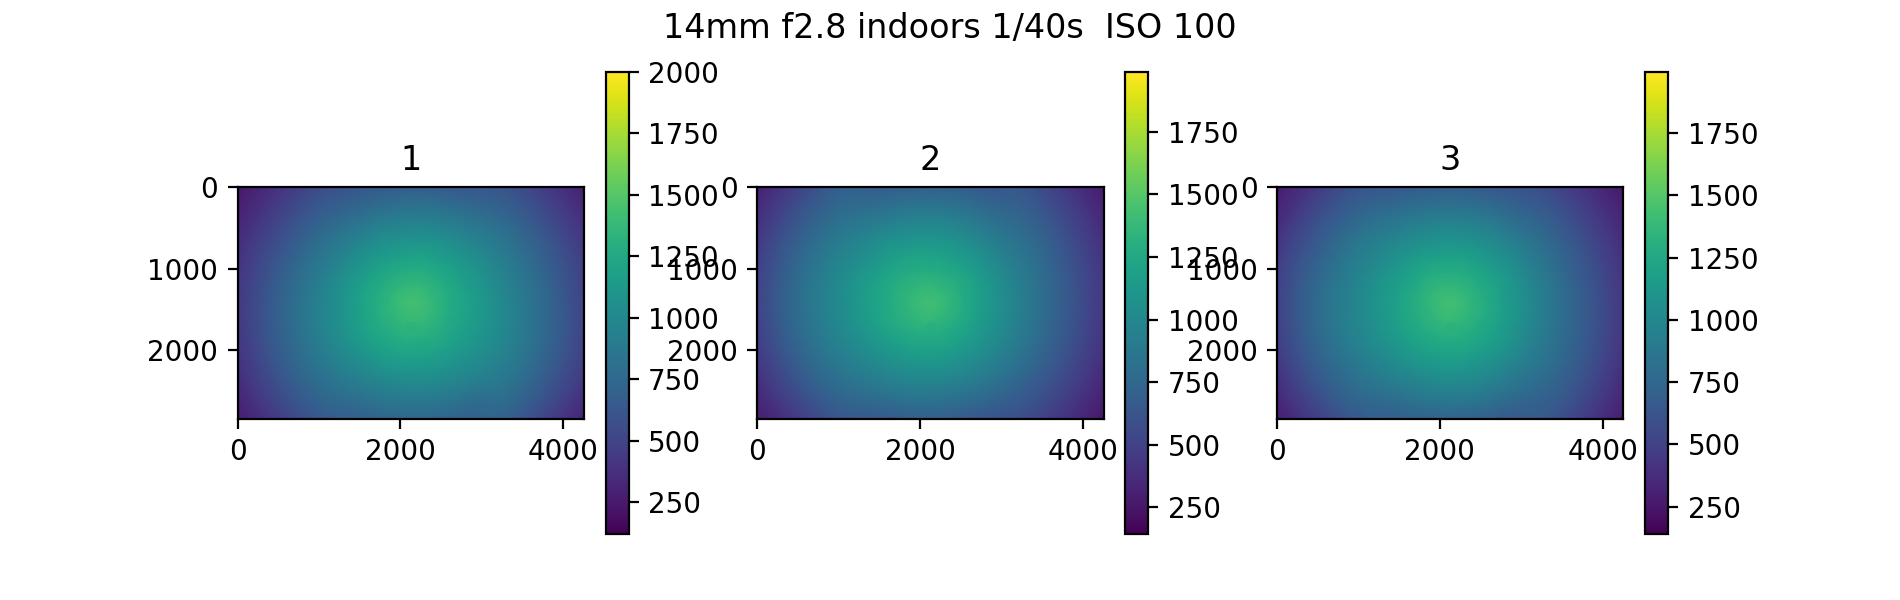

<IPython.core.display.Javascript object>


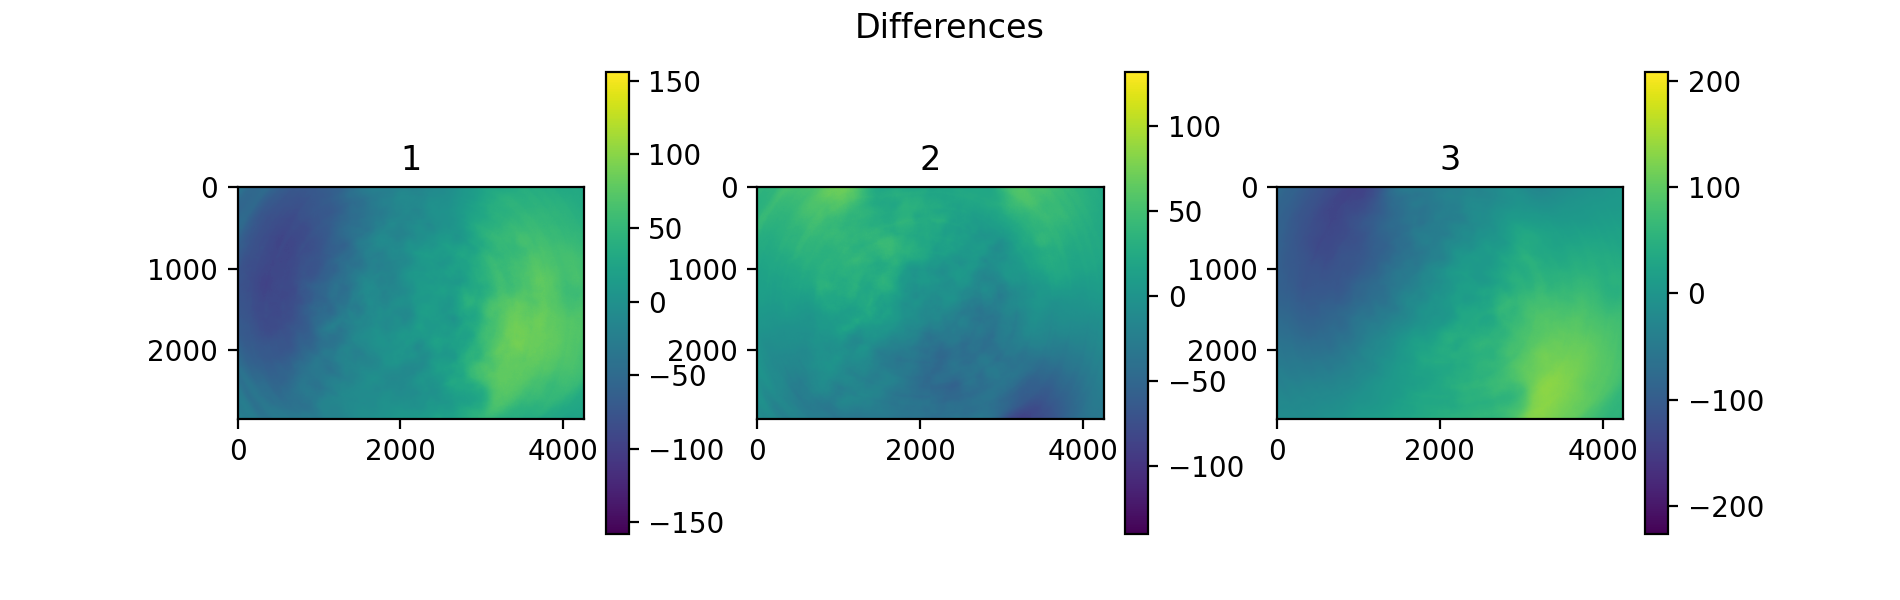

CPU times: user 24.4 s, sys: 3.86 s, total: 28.3 s
Wall time: 28.5 s


In [6]:
%%time
# Flats made indoors - 14mm f2.8
list_raw = glob.glob(path + 'raw_1/*.ARW')
process(list_raw, slice(0,30), slice(31,60), slice(61,90), '14mm f2.8 indoors', combination_function=np.median)

<IPython.core.display.Javascript object>


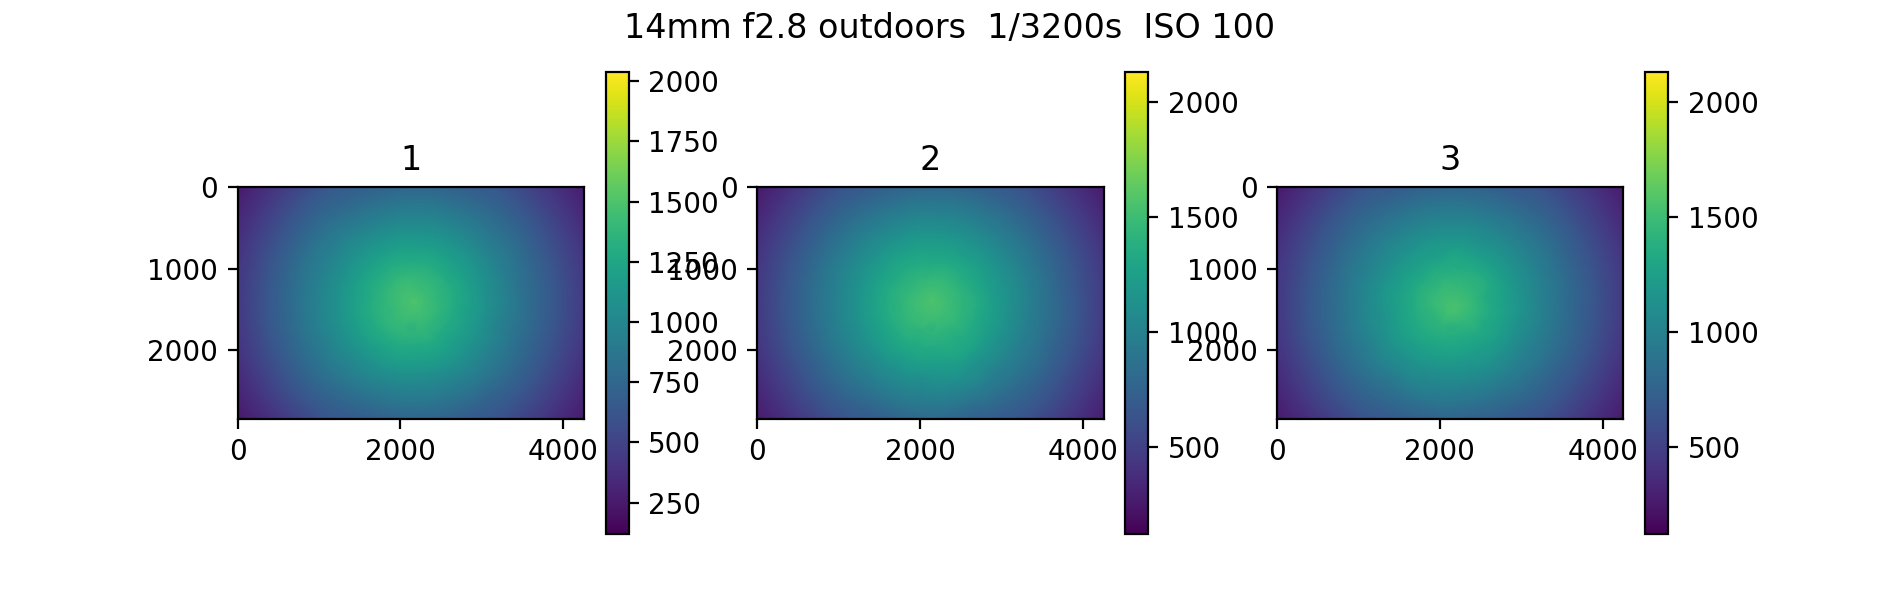

<IPython.core.display.Javascript object>


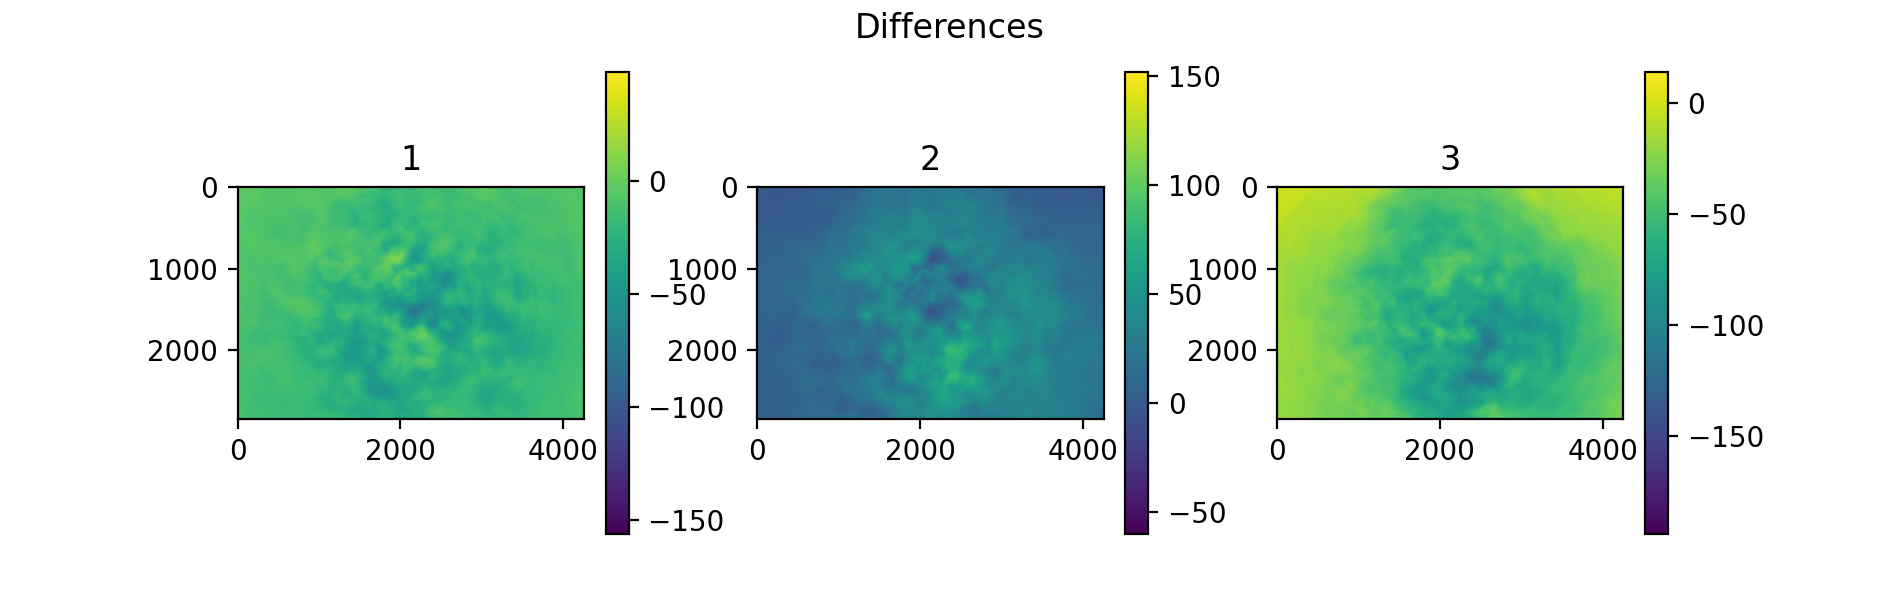

CPU times: user 24.6 s, sys: 4.45 s, total: 29.1 s
Wall time: 30.1 s


In [7]:
%%time
# Flats made outdoors - 14mm f2.8
list_raw = glob.glob(path + 'raw_2/*.ARW')
process(list_raw, slice(0,30), slice(31,60), slice(61,90), '14mm f2.8 outdoors ', combination_function=np.median)

<IPython.core.display.Javascript object>


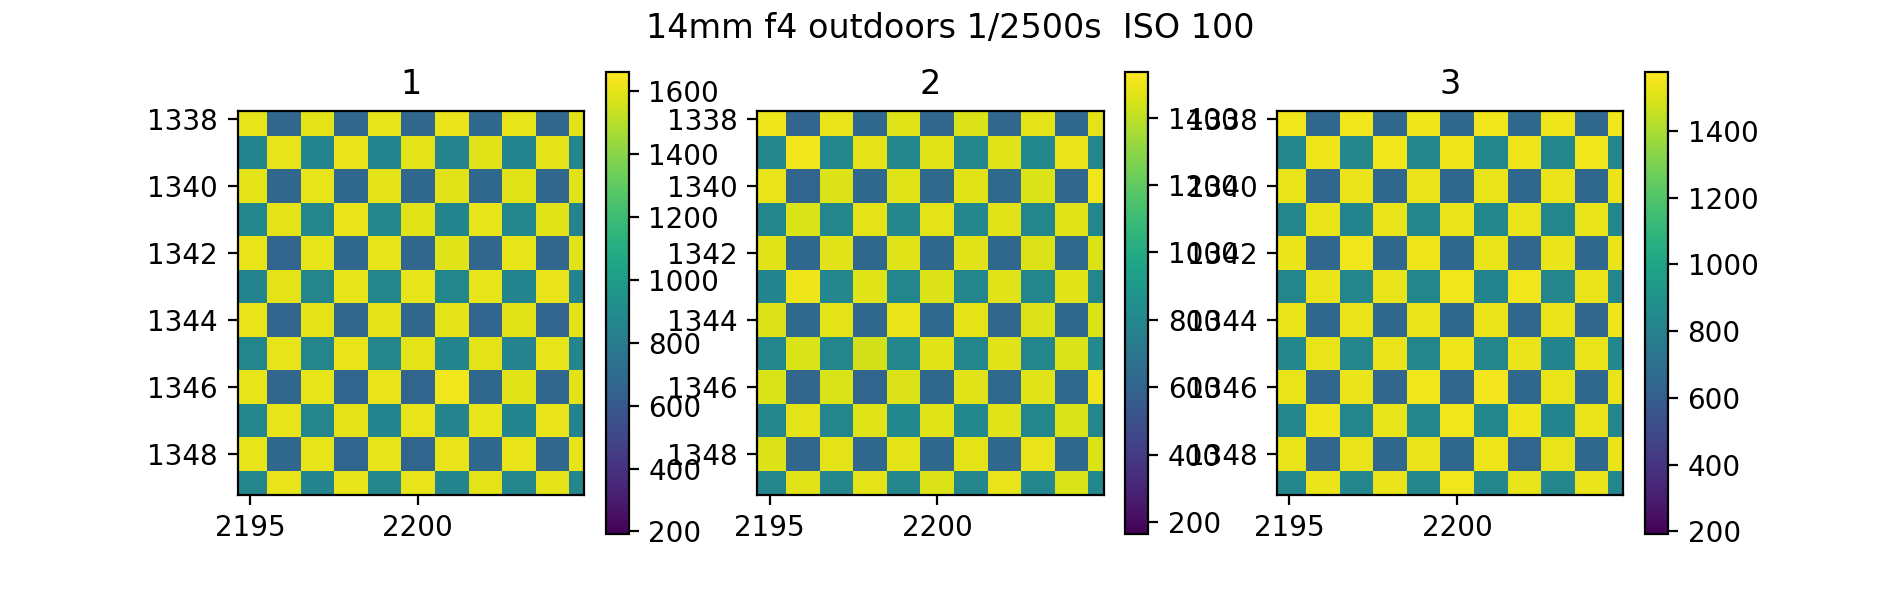

<IPython.core.display.Javascript object>


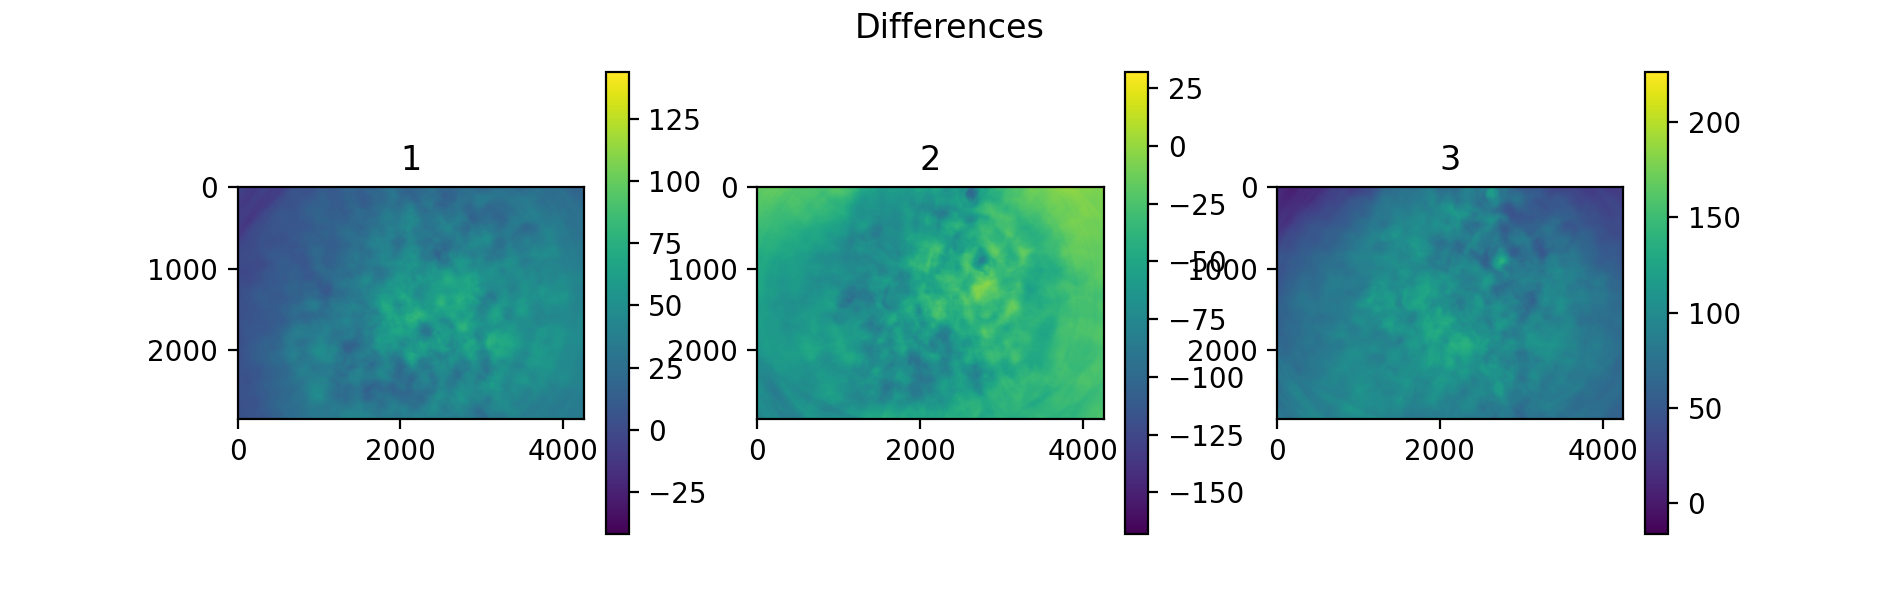

CPU times: user 24.4 s, sys: 4.49 s, total: 28.9 s
Wall time: 29.8 s


In [8]:
%%time
# Flats made outdoors - 14mm f4 for comparison with the f2.8 data sets.
list_raw = glob.glob(path + 'raw_f4/*.ARW')
process(list_raw, slice(0,30), slice(31,60), slice(61,90), '14mm f4 outdoors', combination_function=np.median)

### Conclusion

The difference plots are more uniform, with less structure, for the outdoors subset. Note that the range in DN in these plots is mostly coming from the fact that we have the three RGB colors still mixed together in these non-debayred arrays. Thus no direct noise measurements of the flat field can be made there.

From the diff plots, we can conclude that the best flat field can be derived from the median combination of the 90 frames taken outdoors.

## Analysis of noise in each color channel

Because we cannot extract noise information directly from the raw images, we use standard debayerization to build interpolated RGB arrays. This is justified by the fact that the flat field is very smooth and in practice any interpolation technique applied in the color sub-arrays should give essentially the same result.



In [9]:
%%time
# Build combination from entire data set. Here we use a similar procedure as
# defined in function combine_arrays, but work with the de-bayered arays. Step
# over every other frame to minimize kernel shutdown problems.
list_raw = glob.glob(path + 'raw_2/*.ARW')[::2]

# Build stack. We do not use the scipy/numpy stacking functions because 
# they clog memory.
stack_r = None
stack_g = None
stack_b = None

for fname, i in zip(list_raw, range(len(list_raw))):

    # Read and de-bayer each raw file into a linear image.
    # These settings preserve the raw pixel values into 
    # the output RGB array.
    with rawpy.imread(fname) as raw:
        rgb = raw.postprocess(gamma=(1,1), 
                              output_bps=16,
                              use_camera_wb=False,
                              use_auto_wb=False,
                              no_auto_bright=True, 
                              no_auto_scale=True,
                              output_color=rawpy.ColorSpace.raw)
        red = rgb[::,::,0]
        green = rgb[::,::,1]
        blue = rgb[::,::,2]

        if stack_r is None:            
            stack_r = np.zeros(shape=(red.shape[0],red.shape[1],len(list_raw)), dtype='float32')
            stack_g = np.zeros(shape=(red.shape[0],red.shape[1],len(list_raw)), dtype='float32')
            stack_b = np.zeros(shape=(red.shape[0],red.shape[1],len(list_raw)), dtype='float32')

        stack_r[:,:,i] = red
        stack_g[:,:,i] = green
        stack_b[:,:,i] = blue

        print(i, fname)

print("Stack shape: " + str(stack_r.shape))

# Combine 
c_red = np.median(stack_r, axis=2)
c_green = np.median(stack_g, axis=2)
c_blue = np.median(stack_b, axis=2)

0 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06737.ARW
1 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06722.ARW
2 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06720.ARW
3 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06735.ARW
4 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06709.ARW
5 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06731.ARW
6 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06718.ARW
7 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06724.ARW
8 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06726.ARW
9 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06733.ARW
10 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06783.ARW
11 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06754.ARW
12 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06741.ARW
13 ../astrophotography_data/MilkyWayPrettyBoy/flats/raw_2/DSC06769.ARW
14 ../astrophoto

<IPython.core.display.Javascript object>


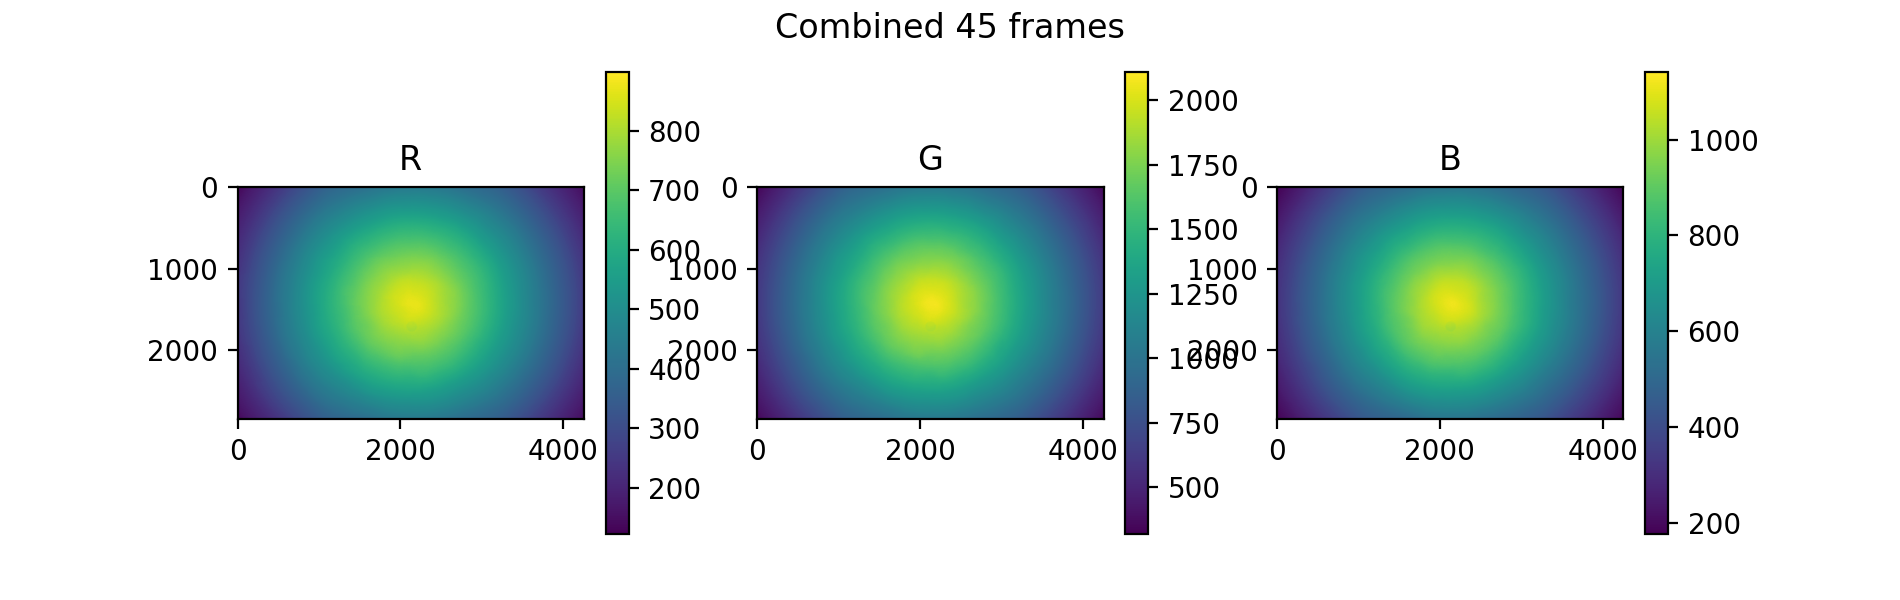

In [10]:
plot_multiple([c_red, c_green, c_blue], 'Combined '+str(len(list_raw))+' frames', labels=['R','G','B'])

In [11]:
# Stats
def stats(array, x, y, size, name):
    slice_x = slice(x,x+100)
    slice_y = slice(y,y+100)
    mean = np.mean(array[slice_x,slice_y])
    std = np.std(array[slice_x,slice_y])
    print(name, "  mean =", mean, "stddev =", std, "S/N =", str(mean/std))

size = 100

x = int(c_red.shape[0] / 2)
y = int(c_red.shape[1] / 2)
stats(c_red, x, y, size, "Center R:")
stats(c_green, x, y, size, "Center G:")
stats(c_blue, x, y, size, "Center B:")

x = 10
y = 10
stats(c_red, x, y, size, "Corner R:")
stats(c_green, x, y, size, "Corner G:")
stats(c_blue, x, y, size, "Corner B:")

Center R:   mean = 869.425 stddev = 6.5590835 S/N = 132.55281
Center G:   mean = 2068.817 stddev = 11.42419 S/N = 181.09091
Center B:   mean = 1111.4976 stddev = 8.003524 S/N = 138.87602
Corner R:   mean = 157.34 stddev = 9.443538 S/N = 16.661129
Corner G:   mean = 393.1965 stddev = 19.142218 S/N = 20.540802
Corner B:   mean = 204.4381 stddev = 8.697561 S/N = 23.50522
